In [86]:
%matplotlib inline

In [138]:
import pandas as pd
import pymc3 as pm
import numpy as np

from scipy.optimize import fmin_powell
import matplotlib.pyplot as plt

In [2]:
results = pd.read_csv('../data/parsed_data.csv')

In [62]:
results['ice_out'] = pd.to_datetime(results['ice_out'])
results.head()
results1 = results[(results.Year>=1950)&(results.Year<=2016)][['Year', 'JDOY']].copy()
results1.columns = ['Year', 'iceout']

In [39]:
df = pd.read_csv('../data/PANN.csv', parse_dates=['date'], index_col='date')
df = df.dropna(how='all', axis=1)
df2 = df.resample('W-SUN').mean()
df.head()

,actual_mean_temp
date,
1949-10-01,36
1949-10-02,36
1949-10-03,33
1949-10-04,30
1949-10-05,31


In [40]:
df2['week'] = df2.index.week
df2['year'] = df2.index.year
# push OCT, NOV, and DEC into the appropriate Ice Classic Results Year
df2['year'] = np.where(df2.index.month == 10, df2.year+1, df2.year)
df2['year'] = np.where(df2.index.month == 11, df2.year+1, df2.year)
df2['year'] = np.where(df2.index.month == 12, df2.year+1, df2.year)

In [41]:
df2.head()

,actual_mean_temp,week,year
date,,,
1949-10-02,36.000000,39,1950
1949-10-09,30.285714,40,1950
1949-10-16,22.857143,41,1950
1949-10-23,30.285714,42,1950
1949-10-30,28.857143,43,1950


In [71]:
df3 = pd.pivot_table(df2, values='actual_mean_temp', columns='week', index='year')
df3 = df3.dropna(how='all', axis=1).copy()
df3 = df3.drop([53], axis=1)

In [170]:
col_names = df3.columns.tolist()
col_names_corr = []
for col in col_names:
    col = 'week'+str(col)
    col_names_corr.append(col)

In [74]:
df3.columns = col_names_corr

In [171]:
df4 = df3.merge(results1, how='inner', left_index=True, right_on='Year')
df_hold = df4[(df4.Year<=2016)&(df4.Year>=2013)].copy()
df4 = df4[df4.Year<2014]
df4 = df4.drop(['Year'], axis=1)
df_hold = df_hold.drop(['Year'], axis=1)

In [78]:
eq = 'iceout ~ '

for col in col_names_corr:
    eq += ' + '+col

In [83]:
with pm.Model() as models:
    pm.glm.glm(eq, df4, family=pm.glm.families.Normal())

    start_MAP = pm.find_MAP(fmin=fmin_powell, disp=False)
    traces = pm.sample(2000, start=start_MAP, step=pm.NUTS(), progressbar=True)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.59it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000275512F8080>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000002755ABD40F0>]], dtype=object)

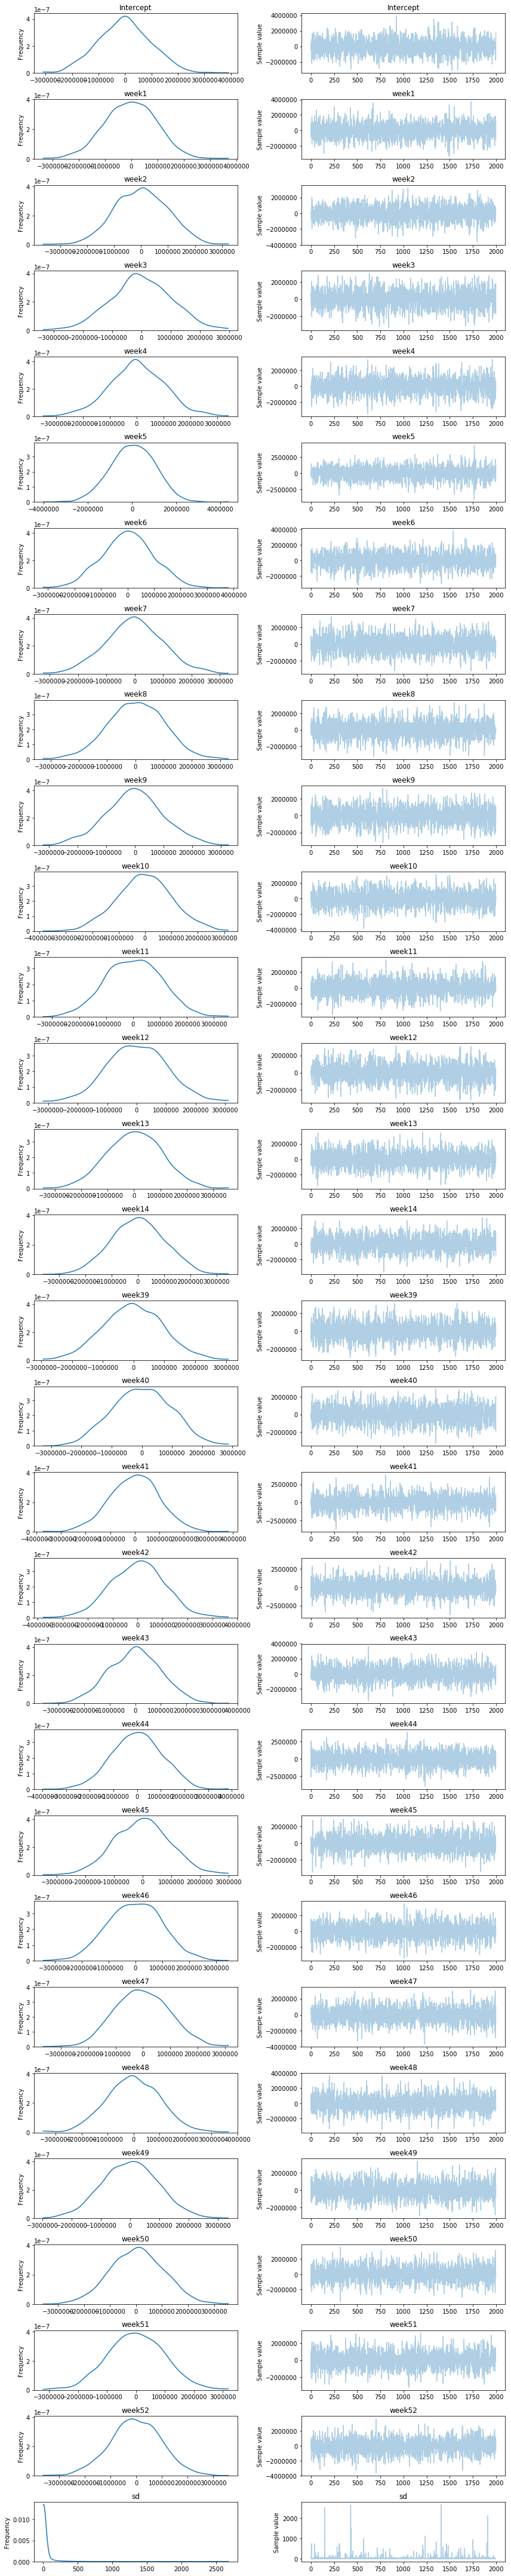

In [87]:
pm.traceplot(traces)